In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qutip import*

In [19]:
'''Initiate parameters'''
gOP=1*2*np.pi   #Optical pumping rate
W=0.01*gOP          # coupling strength in terms of the Rabi frequency
w_L=1*gOP*2e2         #ethalon Larmor frequency
gL=2*w_L          #cavity line width
gT=1.0*gOP          # thermal relaxation rate
delta=np.linspace(-4*w_L,4*w_L,320)# microwave detuning

In [20]:
# Initialize quantum system

states = []  # list with the basis states
for i in np.arange(8):
    states.append(basis(8, i))

psi1_1 = states[0]  #(1,-1) ground state
psi10 = states[1]  #(1,0) ground state
psi11 = states[2]  #(1,+1)ground state
psi2_2 = states[3]  #(2,-2)ground state
psi2_1 = states[4]  #(2,-1)ground state
psi20 = states[5]  #(2,0)ground state
psi21 = states[6]  #(2,+1)ground state
psi22 = states[7]  #(2,+2)ground state

'''projectors onto the basis states'''
P = []
for psi in states:
    P.append(ket2dm(psi))

In [21]:
# Collapse operators

c_ops = []  #list with collapse operators

'''Optical pumping relaxation'''
for psi1 in states[0:3]:
    for psi2 in states[3:]:
        c_ops.append(np.sqrt(gOP) * psi1 * psi2.dag())

'''Thermal relaxation between the Zeeman states'''
for i in np.arange(8):
    for j in np.arange(8):
        if i != j:
            c_ops.append(np.sqrt(gT) * states[i] * states[j].dag())

In [22]:
# Hamiltonian
'''Interaction Hamiltonian'''

S_o=W*np.array([0.5*np.sqrt(3),  0.25*np.sqrt(2), 0.25*np.sqrt(6), 0.25*np.sqrt(6), 0.25*np.sqrt(2),  0.5*np.sqrt(3)])# Rabi frequencies for orthogonal transition
S_l=W*np.array([0.5*np.sqrt(3), 1, 0.5*np.sqrt(3)])# Rabi frequencies for longitudinal transition

#add cavity line-width
def L(f,g):
    if g==0:
        return 1
    return g**2/(g**2+f**2)

def Sl(W_par,W_ort):
    wL=np.sqrt(W_par**2+W_ort**2)
    if wL==0:
        return S_l*np.sqrt(L(np.array([-2,0.0,2])*wL,gL))
    return S_l*W_par/wL*np.sqrt(L(np.array([-2,0.0,2])*wL,gL))

def So(W_par,W_ort):
    wL=np.sqrt(W_par**2+W_ort**2)
    if wL==0:
        return 0*S_o*np.sqrt(L(np.array([-3,-1,-1,1,1,3])*wL,gL))
    return S_o*W_ort/wL*np.sqrt(L(np.array([-3,-1,-1,1,1,3])*wL,gL))



"interaction part of the Hamiltonian as a function of Larmor frequency"
def V(W_par,W_ort):
    V_l=0*qeye(len(states))
    V_o=0*qeye(len(states))

    for i in range(3):
        V_l+=0.5*Sl(W_par,W_ort)[i]*(states[i]*states[i+4].dag())+0.5*Sl(W_par,W_ort)[i]*(states[i]*states[i+4].dag()).dag()#pi transition
        V_o+=0.5*So(W_par,W_ort)[2*i]*(states[i]*states[i+3].dag())+0.5*So(W_par,W_ort)[2*i]*(states[i]*states[i+3].dag()).dag()#sigma-
        V_o+=0.5*So(W_par,W_ort)[2*i+1]*(states[i]*states[i+5].dag())+0.5*So(W_par,W_ort)[2*i+1]*(states[i]*states[i+5].dag()).dag()#sigma+
    return V_o+V_l


'''Diagonal part of the Hamiltonian as a function of detuning d form the clock transition and the Larmor frequency'''
def H_d(d, wL):
    H=0*qeye(len(states))
    H+=(wL+0.5*d)*P[0]
    H+=0.5*d*P[1]
    H+=(-wL+0.5*d)*P[2]
    H+=-(0.5*d+2*wL)*P[3]
    H+=-(0.5*d+wL)*P[4]
    H+=-0.5*d*P[5]
    H+=-(0.5*d-wL)*P[6]
    H+=-(0.5*d-2*wL)*P[7]
    return H

'''Total Hamiltonian'''
def H(d,W_par,W_ort):
    wL=np.sqrt(W_par**2+W_ort**2)
    H=H_d(d,wL)+V(W_par,W_ort)
    return H

In [26]:
# Find the steady state

W_par = 0 # Parallel component of the microwave field in terms of Rabi frequency
W_ort = 1 # Orthogonal component of the microwave field in terms of Rabi frequency

ss_1=[] # Steady-state population in F=1, mF=-1
ss0=[] # Steady-state population in F=1, mF=0
ss1=[] # Steady-state population in F=1, mF=1
for d in delta:
    ss=steadystate(H(d,W_par*w_L,W_ort*w_L), c_ops, drop_tol=1e-10) #steady state
    ss_1.append(expect(P[0],ss))#steady-state populations of psi1
    ss0.append(expect(P[1],ss))#steady-state populations of psi2
    ss1.append(expect(P[2],ss))#steady-state populations of psi3
##convert to arrays
ss_1=np.array(ss_1)
ss0=np.array(ss0)
ss1=np.array(ss1)
rho=ss_1+ss0+ss1


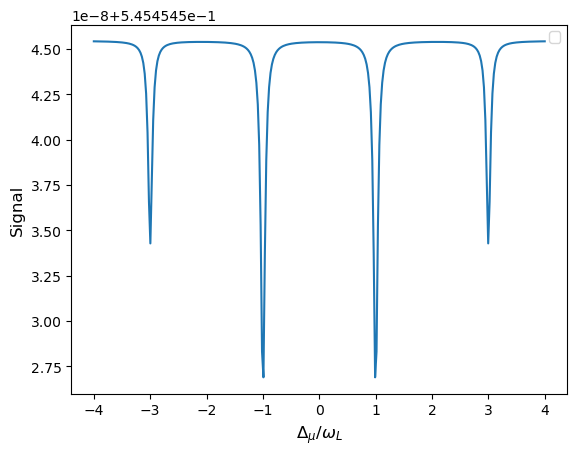

In [27]:
fig, ax = plt.subplots()
ax.plot(delta/w_L, rho)
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$',fontsize=12)
ax.set_ylabel('Signal',fontsize=12)
ax.legend(loc=0)